# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date: 10 November 2023**

# Notebook 03A. Labelled Dataset - "Bag of Words" Modelling  - Yes and No only

## Introduction

In this notebook, I focus on modelling using the labelled up-sampled dataset. 

My labelled dataset has 5 classes of "Intent" - 'yes', 'maybe', 'uncertain', 'informative' and 'no'. I experimented with different strategies of binary encoding my target variable "Intent". This involved exploring a range of encoding strategies and class combinations. To determine the most effective approach, I tested various classification models with different encodings combinations.

The encoding strategies I experimented with include:
1. Encoding "yes" answers as 1s and all other responses as 0s.
2. Encoding all "no" responses as 1s (thus creating a one-versus-all class scenario).
3. Combining "yes" and "no" responses into a single class.
4. Combining "yes" and "maybe" into one class. While this approach yielded good statistical results, it didn't help in identifying negative opinions effectively.

Ultimately, I settled on two primary encoding strategies that aligned best with my data and objectives:
1. **Encoding both "yes" and "no" categories as 1s**, while eliminating categories like "uncertain", "informative", and "maybe". This approach significantly reduced the dataset's size but was effective in distinguishing between positive and negative messages.
2. **Grouping "yes" and "no" responses into a single category, labeled "relevant"**. These messages, despite having opposite sentiments, express a stance on the attractiveness of shares and are distinct from messages discussing unrelated events or lacking an opinion. The other group, "irrelevant", includes informative and unrelated messages.

I found that these binary labeling strategies proved to be more effective results than multi-class classification models, which I also experimented with. The multi-class models generally performed poorly, often misclassifying the majority of messages into a dominant class. After three attempts with different models, I decided to abandon this approach.

This notebook, titled "Notebook 03-A", delves into the modeling results for the encoding strategy where "yes" and "no" were combined into one category, and other categories were excluded.

"Notebook 03-B" will explore the results of the alternate encoding strategy, differentiating between "relevant" and "irrelevant" classes.

In this notebook I perform basic modelling for the labelled dataset that was upsampled with new 450 messages generated using OpenAI APIs. 

This notebook consists of the following sections:

* 3.0. Loading the data and perfoming data quality checks. 
* 3.1. Regression preparation. Assigning target variable y. Custom tokenization function is defined. Train and text split is made. 
* 3.2. Vectorization.  Most common words identified.  SMOTE sampling set up due to imbalance in data.
* 3.3. Simple logistic regression. Positive and negative coefficients for word tokens. 
* 3.4. Search for the best logistic regression model. 
* 3.5. Decision Tree Classifier
* 3.6. SVM Classifier
* 3.7. Random Forest Model
* 3.8. Conclusions on Yes/No encoding strategy

## 3.0 Data loading and data quality checks

In [1]:
import re
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Set visualization and pandas display options
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

# Set the global font to be used for all text
plt.rcParams['font.family'] = 'Gill Sans'  


# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy

# Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay)

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Dimensionality Reduction
from sklearn.decomposition import PCA, TruncatedSVD

# Pipeline Utilities
from sklearn.pipeline import Pipeline, make_pipeline

# SMOTE for dealing with imbalanced datasets
from imblearn.over_sampling import SMOTE

# Serialization/Deserialization Libraries
from joblib import dump
import dill as pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the pre-processed labelled dataset (result of work done in Notebook 01). 
# This version of the dataset has emojis preserved.
DATAFILE = '../data/02_labelled_dataset_cleaned.csv'
df1 = pd.read_csv(DATAFILE)

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   link_id     4996 non-null   object
 1   parent_id   4996 non-null   object
 2   User        4996 non-null   object
 3   Text        4996 non-null   object
 4   Intent      4996 non-null   object
 5   Support     4996 non-null   object
 6   word_count  4996 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 273.3+ KB


In [4]:
# Dropping non-essential rows that carry no text
df1=df1.drop(columns=['parent_id', 'User', "Support",'word_count']) #"emoji_text"])

In [6]:
df1['link_id'].nunique()

1944

In [7]:
# Rename the 'link_id' column to 'id'
df1 = df1.rename(columns={'link_id': 'id'})

In [8]:
# Counting duplicated rows
df1.duplicated().sum()

3

In [9]:
# Removing duplicate rows
df1 = df1.drop_duplicates()

In [10]:
# Loading the negative messages upsampled using openAi APis:
DATAFILE2 = '../data/reddit_gpt4_negative_only_cleaned.csv'
df2 = pd.read_csv(DATAFILE2)

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               450 non-null    object
 1   title            450 non-null    object
 2   selftext         314 non-null    object
 3   Text             450 non-null    object
 4   token_count      450 non-null    int64 
 5   Sentiment_Tag    450 non-null    object
 6   Sentiment_Tag_2  450 non-null    object
dtypes: int64(1), object(6)
memory usage: 24.7+ KB


In [12]:
# Dropping non-essential or redundant rows:
df2=df2.drop(columns=['title', 'selftext', 'token_count', 'Sentiment_Tag'])

In [13]:
# Rename the 'Sentiment_Tag_2' column to 'Intent'
df2 = df2.rename(columns={'Sentiment_Tag_2': 'Intent'})

In [14]:
df2.describe()

,id,Text,Intent
count,450,450,450
unique,441,441,1
top,mpbyzf,"4/12/2021 GME Borrowables Alert 7.30am, Hey gu...",Negative
freq,2,2,450


In [15]:
# checking for duplicates after the steps above
df2.duplicated().sum()

9

In [16]:
# Dropping the duplicates 
df2.drop_duplicates()

,id,Text,Intent
0,oxwuiw,It absolutely blows my mind that so many peopl...,Negative
1,p72imy,Ruined My Financial Future… This is 99% of my ...,Negative
2,pnelsm,"It’s a lot worse than you think, Most people a...",Negative
3,q7g115,30 years old. Life savings gone. Since April o...,Negative
4,pmcivi,Remember the internet bubble? Here’s me sellin...,Negative
...,...,...,...
445,msla5l,"Gme going to zero, invest in Broccoli futures ...",Negative
446,ril23c,Hilarious how much msm is pumping popcorn toda...,Negative
447,ncf668,"Maybe they shorted GME, nan",Negative
448,mkm697,Sell Order Rejected 🙅‍♂️- I doubt if your deal...,Negative


In [17]:
# Checking the result of the steps above
df2.head(5)

,id,Text,Intent
0,oxwuiw,It absolutely blows my mind that so many peopl...,Negative
1,p72imy,Ruined My Financial Future… This is 99% of my ...,Negative
2,pnelsm,"It’s a lot worse than you think, Most people a...",Negative
3,q7g115,30 years old. Life savings gone. Since April o...,Negative
4,pmcivi,Remember the internet bubble? Here’s me sellin...,Negative


In [18]:
# Replace 'Negative' with 'n' in the 'Intent' column
df2['Intent'] = df2['Intent'].replace("Negative", "n")

In [19]:
# Replace 'NaN' and 'nan' with an empty string in the 'Text' column of df2
df2['Text'] = df2['Text'].str.replace('NaN|nan', '', regex=True)

In [20]:
# Concatenate df and df2 vertically
df = pd.concat([df1, df2], ignore_index=True)
df

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,t3_ki3745,"Oh GME, you tease!",u
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,t3_l9xqem,Just got into $GME @ 220.,y
...,...,...,...
5438,msla5l,"Gme going to zero, invest in Broccoli futures ...",n
5439,ril23c,Hilarious how much msm is pumping popcorn toda...,n
5440,ncf668,"Maybe they shorted GME,",n
5441,mkm697,Sell Order Rejected 🙅‍♂️- I doubt if your deal...,n


In [21]:
df['Intent'].value_counts()

Intent
u    3245
y     983
n     533
m     370
i     312
Name: count, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5443 entries, 0 to 5442
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5443 non-null   object
 1   Text    5443 non-null   object
 2   Intent  5443 non-null   object
dtypes: object(3)
memory usage: 127.7+ KB


* The datasets have been successfully concatenated into one single dataframe. Both have been pre-cleaned using similar steps. 
* We have 5443 rows now to work with.
* Saving the result into a CSV file.  

In [23]:
df.to_csv('../data/03_labelled_GPT_upsampled_.csv', index=True)

Looking at the distribution of our classes in the target colulmn "Intent":

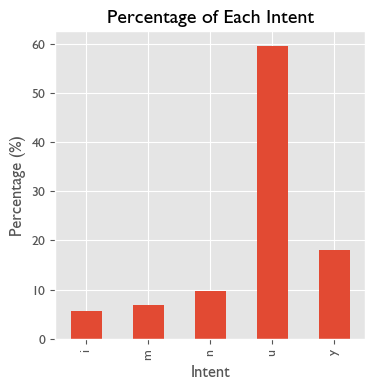

In [24]:
# Calculating the percentage of each intent category relative to the total
intent_percentages = df['Intent'].value_counts(normalize=True).sort_index() * 100

# Plotting the percentages
ax = intent_percentages.plot(kind='bar', title='Percentage of Each Intent', figsize=(4, 4))
ax.set_xlabel('Intent')
ax.set_ylabel('Percentage (%)')

# Display the plot
plt.show()

* Majority of posts (60%) received clasification 'u', which means 'uncertain'. 
* 18% of posts were rated as "positive" signalling an intent to buy GME shares.
* Negative messages ('n') are still a minority, only  10% of the messages were rated as "negative" which still creates an  imbalance in our dataset.  I still have a deficit of examples of negative posts, but this is much better than before.

## 3.1. Assigning target variable

In [25]:
df.head(5)

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,t3_ki3745,"Oh GME, you tease!",u
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,t3_l9xqem,Just got into $GME @ 220.,y


In [26]:
# Droppinhg the rows where 'Intent' is 'm', 'i', or 'u'
df = df[~df['Intent'].isin(['m', 'i', 'u'])]

In [27]:
# Assigning target variable to (Y) = 1, and (N)= 0. All other rows have been dropped already.

df = df.copy() 

# Two classes together as 1s
#df['Intent'] = np.where((df['Intent'] == 'y')  | (df['Intent'] == 'n'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y') | (df['Intent'] == 'm'), 1, 0)

# Only one class as 1s
df['Intent'] = np.where((df['Intent'] == 'y'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y'),1, 0)

df.head()

,id,Text,Intent
4,t3_l9xqem,Just got into $GME @ 220.,1
6,t3_l2lfqs,Just doubled my position on GMELet’s HOLDDDDDD...,1
11,t3_kkv8mc,this is what people who grew up rich have to d...,1
12,t3_l35s4w,"I put my stocks in a way that, should I someho...",1
26,t3_l84ner,E*TRADE has been reliable on Friday. I bought ...,1


In [28]:
df['Intent'].value_counts()

Intent
1    983
0    533
Name: count, dtype: int64

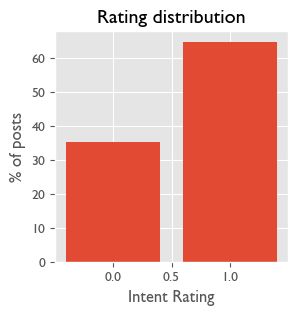

Class imbalance: [0.35 0.65]


In [29]:
# Checking the distribution of binary classes:

values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Intent Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()


print(f"Class imbalance: {np.round(normalized_counts, 2)}")

### 2.1.1. Tokenization options

In the dataset I've been working with, the primary focus is on the intention to buy shares in GameStop, a company that was a hot topic in the WallStreetBets (WSB) community during Q1 2021. Given that the discussions frequently centred around GameStop, identified by its name or its stock exchange ticker "GME", it was crucial for my analysis to filter out these specific references. This is because I wanted to ensure that my model could effectively identify buy or sell recommendations without being biased towards discussions solely focused on  GameStop. 

Additionally, other companies like Blackberry ("BB") and AMC were also popular in these discussions. To address this, I crafted a custom list of stop words designed to exclude these specific company names and tickers from my textual analysis. By incorporating this custom stop words list into my bag-of-words analysis, I wanted to create a more robust model that could generalize across various company discussions, rather than being narrowly focused on a few frequently mentioned ones.

Finally, I experimented with lemmatisation and stemmation and their combinations, and for this particular dataset and the BOW approach the bets results are achieved when both stemmation and lemmatisation is applied, resulting in approximately 5% pickup in combined F1 ratio across best models, as compared to the situation when only lemmatisation is applied.  So, in my final code I used both.



In [28]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ['gamestop', 'gme', 'amc', 'nok', 'bb', "game", 'pltr', 'spy']

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

the code below is my custom cleaning function designed for the BOW (bag of words) approach. 

In [29]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=True):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document

#### External popular tokenizers loaded

I want to experiment with a few different tokenizers to see which one works best for my specific project, especially considering the informal and varied nature of social media language. 

 I downloaded several popular tokenizers used for social media posts, and used them in my gridsearch below, to see which one performs better.  In the end, I settled on using my own tokeniser, although spaCy tokeniser also showed good results. I commented out the code where I experimented with various tokenisers (but not deleted it). 

1. spaCy is a robust and efficient tokenizer that is great for general-purpose text processing. It's particularly good at handling complex and noisy text. spaCy's processing is more sophisticated than simpler tokenization methods, so it is more computationally intensive.

In [30]:
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Tokenizing the document and filtering out punctuation, spaces, and other unwanted tokens
def spacy_tokenizer(document):
    return [token.text for token in nlp(document) if 
            token.is_alpha and  # This keeps only alphabetic tokens
            #token.text.lower() not in ["'s", "n't", "’s", "n’t", "’m"] and
            not token.is_punct and 
            not token.is_currency
            ]              

# Preprocess each stop word with the tokenizer
processed_stop_words_spacy = set(token for word in stop_words for token in spacy_tokenizer(word))

# Display the processed stop words
print(processed_stop_words_spacy)

{'might', 'very', 'by', 'needn', 'than', 'when', 'how', 'is', 'she', 'such', 'its', 'should', 'each', 'from', 'why', 'more', 'did', 'you', 'a', 'of', 'their', 'which', 'too', 'm', 'as', 'during', 'nor', 've', 'game', 'doing', 'can', 'down', 'they', 'didn', 'in', 'o', 'this', 't', 'your', 'but', 'he', 'wo', 'most', 'has', 'for', 'itself', 'being', 'were', 'after', 'doesn', 'them', 'spy', 'or', 'because', 'sha', 'will', 'now', 'our', 'themselves', 'until', 'and', 'once', 'some', 'wasn', 'shouldn', 'nok', 'through', 'up', 're', 'i', 'herself', 'was', 'at', 'am', 'yourselves', 'whom', 'd', 'couldn', 'no', 'same', 'then', 'amc', 'don', 'll', 'mustn', 'do', 'had', 'there', 'mightn', 'own', 'pltr', 'been', 'me', 'all', 'an', 'isn', 'that', 'on', 'into', 'few', 'these', 's', 'off', 'wouldn', 'about', 'to', 'are', 'who', 'just', 'would', 'ours', 'theirs', 'not', 'gme', 'the', 'be', 'over', 'ain', 'hers', 'yours', 'need', 'won', 'both', 'any', 'below', 'my', 'shan', 'where', 'must', 'aren', 'hav

2. TweetTokenizer from NLTK is specifically designed for tokenizing tweets, so I thought that it could be effective for Reddit, a similar social media text style. It's good at handling special characters in social media text, like hashtags, mentions, and emojis. It was not as good as spaCy tokeniser though. 

In [31]:
#from nltk.tokenize import TweetTokenizer
#tokenizer_tweets = TweetTokenizer()

3. BERT's tokenizer handles subword tokenization, and this is usually very useful for social media text with slangs and non-standard words, like Reddit posts in my dataset.  I tried using BERT base model first, but it is not deisgned to handle long text (max 512 token per chunk, whereas the dataset i have has longer posts.  

I then tried the Longformer and BigBird transformers modeltokenisers. Longformer was developed by researchers at Allen Institute for AI and is designed for processing long documents by extending the standard Transformer attention mechanism (it can handle sequences up to 4,096 tokens). BigBird was developed at Google, alos can handle up to 4,096 tokens in one sequence. 

Unfortunately, I could not make it work, as the results of tokenisation did not sit well with the rest of the code, giving me constant errors during the gfridsearch process, so I abandoned my efforts after many attempts to fix it. 

In [32]:
# from transformers import BertTokenizer
# tokenizer_BERT = BertTokenizer.from_pretrained('bert-base-uncased')

# For Longformer
#from transformers import LongformerTokenizer
#tokenizer_longformer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# For BigBird
# from transformers import BigBirdTokenizer
# bigbird_tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')

4. StanfordNLP / Stanza tokenizer was eveloped by Stanford University. It is more resource-intensive than others, but offers state-of-the-art accuracy. I wanted to try that, too, but it was too computationally heavy and was taking a very long time to process my text, so I also abandoned it.

In [33]:
# import stanza

# Initialize Stanza pipeline
#stanza.download('en')  # Download the English model
#nlp_stanza = stanza.Pipeline(lang='en')

# Define a custom tokenizer using Stanza
#def stanza_tokenizer(text):
#    doc = nlp_stanza(text)
#    return [word.text for sent in doc.sentences for word in sent.words]

### Train test split

In [34]:
X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(1212,)

In [35]:
print(y_test.shape)

(304,)


## 3.2. Vectorisation 

In [36]:
# Initialise a CountVectorizer object
count_vectorizer = CountVectorizer(tokenizer=my_tokenizer,
                                   stop_words=stop_words, # using stop words list that has been customised
                                   min_df=10, 
                                   ngram_range=(1,2), 
                                   max_features=1000)

# Preprocess the stop words with the custom tokenizer
processed_stop_words = set(my_tokenizer(' '.join(stop_words)))

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(X_train)

# Fit the CountVectorizer object on X_train
X_matrix_train = count_vectorizer.transform(X_train)

print(X_matrix_train.shape);

(1212, 563)


In [37]:
# count the  most common words
word_counts = pd.DataFrame(
        {"counts": np.array(X_matrix_train.sum(axis=0)).flatten()},
        index=count_vectorizer.get_feature_names_out()).sort_values("counts", ascending=False)

print('The most common words and their counts are:')
word_counts[:20]

The most common words and their counts are:


,counts
put,397
buy,391
stock,363
share,346
go,272
like,265
sell,259
hold,230
get,222
money,221


the list of words is pretty much as expected, with a heavy focus on investment related words - stock, share, buy, sell, holding, money, market, etc.  No surprises here. 

In [38]:
#toarray() method converts sparse matrix to a DataFrame
pd.DataFrame(X_matrix_train.toarray(),columns=count_vectorizer.get_feature_names_out()).head()

,abl,absolut,accord,account,action,actual,ad,add,advic,afford,...,wsb,x,ye,yeah,year,year old,yesterday,yet,yolo,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


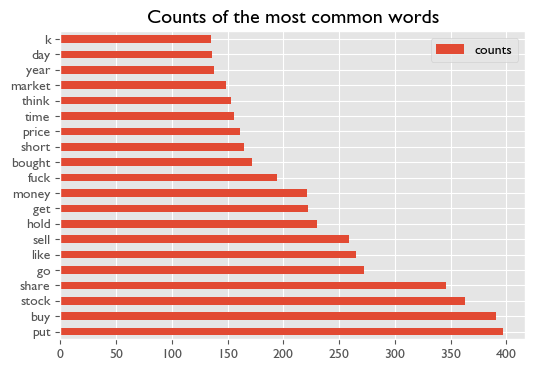

In [39]:
word_counts[:20].plot(kind='barh',title='Counts of the most common words')
plt.show()

In [40]:
print(word_counts)

         counts
put         397
buy         391
stock       363
share       346
go          272
...         ...
list         10
eat          10
howev        10
histori      10
convinc      10

[563 rows x 1 columns]


### SMOTE sampling due to imbalance

* My dataset is imbalanced with 35% of data being in the negative class. 
* I decided to experiment with resampling the data it using SMOTE technique (synthetic up-sampling). 
* SMOTE helps to mitigate the bias towards the majority class in an imbalanced dataset by generating synthetic samples for the minority class. 
* I expected better results as this should have increased my model's ability to learn from an equally represented dataset, improving its predictive accuracy across all classes. 
* However, the SMOTE upsampling generally did not help muhc, as can be shown later. 

In [41]:
# instantiate SMOTE sampler, fit it to the training data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_matrix_train, y_train)

In [42]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


Intent
0    426
1    786
Name: count, dtype: int64


Resampled class distribution


Intent
0    786
1    786
Name: count, dtype: int64

In [43]:
# scale the sampled train data and the unsampled test data
# ss_sm = StandardScaler().fit(X_train_sm)
# X_train_sm_ss = ss_sm.transform(X_train_sm)
# X_test_ss = ss_sm.transform(X_test)

## 3.3. Simple Logistic Regression

In [44]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(304, 563)

In [45]:
logistic_model=LogisticRegression(solver='lbfgs', max_iter=1000) # Also tried  liblinear solver - good for small datasets
logistic_model.fit(X_matrix_train,y_train)
print(f"Train set accuracy {logistic_model.score(X_matrix_train,y_train):.2f}")
print(f"Test set accuracy {logistic_model.score(X_matrix_test,y_test):.2f}")

# Make predictions on the test set
test_predictions = logistic_model.predict(X_matrix_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Train set accuracy 0.94
Test set accuracy 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.53      0.63       107
           1       0.78      0.91      0.84       197

    accuracy                           0.78       304
   macro avg       0.78      0.72      0.74       304
weighted avg       0.78      0.78      0.77       304

Confusion Matrix:
[[ 57  50]
 [ 17 180]]


The baseline logistic regression model shows strong performance on the training set, achieving an accuracy of 94%. However, the accuracy on the test set is 78%, which, while still good, suggests a decrease in performance when applied to unseen data. This indicates some overfitting, which is not unexpected given the dataset's size.

The model shows a somewhat balanced performance across both classes on precision and recall. For the negative class (0s), it achieves a precision of 77% and a recall of 53%, indicating a moderate ability in identifying true negatives. This is natural given that this is only 1/3 of the dataset. In the case of the positive class (1s = yes), the precision is nearly similar at 78%, but with a notably higher recall of 91%. This suggests that the model is more effective in identifying true positives.

The overall accuracy of 78% is ok, but it is not vastly higher than the majority class percentage (73%). The f1-score, which is a harmonic mean of precision and recall, stands at 0.63 for the negative class and 0.84 for the positive class.

Looking at the confusion matrix, we can see that the model is more inclined towards correctly predicting positive intentions (180 correct predictions out of 197 instances) compared to negative intentions (57 correct predictions out of 107 instances). This is a high percent of "misses" on the negative side.

Overall, while the model shows a good baseline performance, especially in predicting the positive class, it could benefit from further tuning to enhance its accuracy and balance between the classes.

Below I explore more complex models and techniques that lead to improved results.

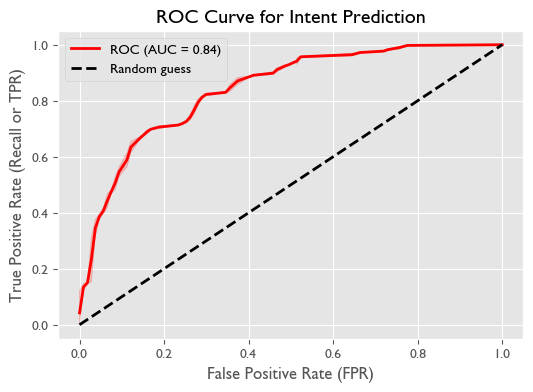

In [46]:
# probabilistic prediction
y_test_proba = logistic_model.predict_proba(X_matrix_test)[:,1] 

# ROC arrays
fprs, tprs, thresholds = roc_curve(y_test, y_test_proba)

# AUC
roc_auc = roc_auc_score(y_test, y_test_proba)

# plot
plt.figure()
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})')  # Corrected line
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')  # Corrected line and added linestyle for clarity

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.title('ROC Curve for Intent Prediction')
plt.legend(loc='best')
plt.show()

The ROC AUC shows decent performance, even befor ethe hyperparameters optimisation. 

Train set accuracy after SMOTE 0.92
Test set accuracy after SMOTE 0.79
Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       107
           1       0.85      0.82      0.83       197

    accuracy                           0.79       304
   macro avg       0.77      0.78      0.77       304
weighted avg       0.79      0.79      0.79       304

Confusion Matrix after SMOTE:
[[ 79  28]
 [ 36 161]]


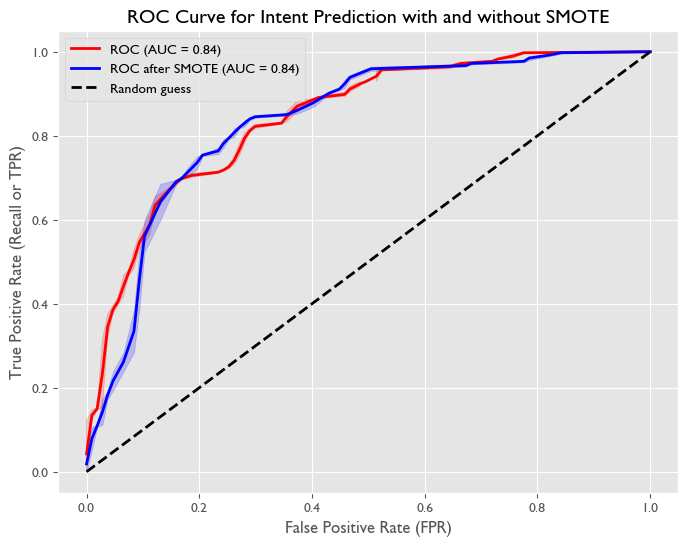

In [47]:
# Logreg with SMOTE

# Initialize the logistic regression model
logistic_model_sm = LogisticRegression(solver='liblinear', max_iter=1000)

# Fit the model on the SMOTE resampled training data
logistic_model_sm.fit(X_train_sm, y_train_sm)

# Evaluate the model on the original training set
print(f"Train set accuracy after SMOTE {logistic_model_sm.score(X_train_sm, y_train_sm):.2f}")

# Evaluate the model on the test set
print(f"Test set accuracy after SMOTE {logistic_model_sm.score(X_matrix_test, y_test):.2f}")

# Make predictions on the test set using the model trained on SMOTE data
test_predictions_sm = logistic_model_sm.predict(X_matrix_test)

# Print classification report
print("Classification Report after SMOTE:")
print(classification_report(y_test, test_predictions_sm))

# Print confusion matrix
print("Confusion Matrix after SMOTE:")
print(confusion_matrix(y_test, test_predictions_sm))

# Get probabilistic predictions
y_test_proba_sm = logistic_model_sm.predict_proba(X_matrix_test)[:,1]

# ROC arrays
fprs_sm, tprs_sm, thresholds_sm = roc_curve(y_test, y_test_proba_sm)

# AUC
roc_auc_sm = roc_auc_score(y_test, y_test_proba_sm)

# Combined Plot
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})') # without SMOTE
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')

plt.title('ROC Curve for Intent Prediction with and without SMOTE')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.legend(loc='best')
plt.show()

The SMOTE technique was applied to reduce imbalance in the dataset between positive and negative classes.  Unfortunately, the SMOTE adjusted data did not result in a substantially better result. Overall, the confidence of the model have somewhat improved compared to the baseline simple logistric regresison, with the macro Fa1 score improving, but ROC AUV is the same.

### Simple Logistic Regression - Coefficients

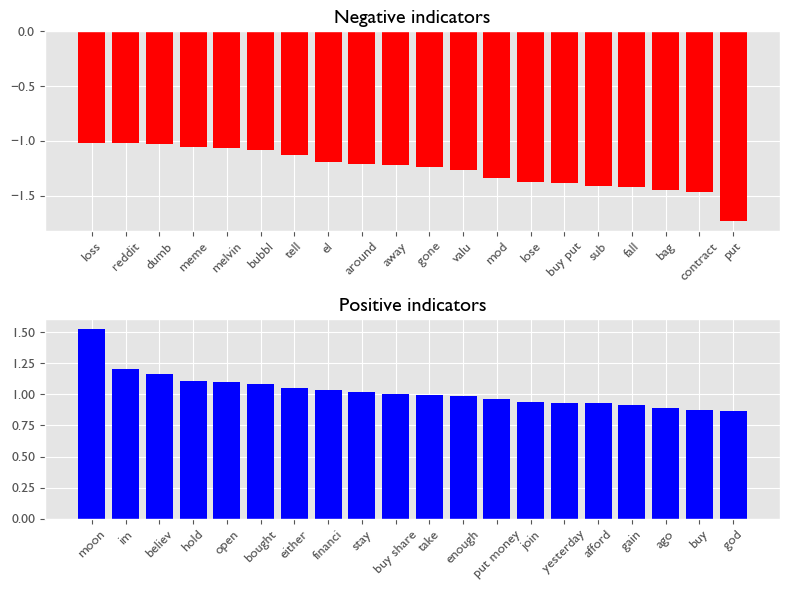

In [48]:
def plot_coefs(model):
    # Create a DataFrame to store the coefficients 
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "token": count_vectorizer.get_feature_names_out()})
    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Plot tokens with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

plot_coefs(logistic_model)

**Observation:**

* It is always useful to see the most important positive and negative word tokens coefficients.  
* Intention to buy stock is associated with words such as "bought", "hold/holding", "buy share", 'believe',  "put money". The inention to buy is associated with the time ("open", "yesterday", "tomorrow"), as well as observation of the stock price performance or the autor's expectation of it:  "gain", "moon" , etc.  However the positive list is full of words that normally do not necessarily show positive intentions to buy securities - many neutral words such as "ago", "take" and "enough" and even swearing words, which are not necessarily investment related. This suggests that we dont have sufficient number of observations in our dataset. 
* We can see a similar picture with the negative coefficients, indicating lack of intention to buy: negative sentiment can be sensed in words such as 'put" (a financial instrument), "loosing", "fall", 'loss", "bubble", 'bag" (for "bagholders'). However, the list is full of neutral words such as 'away', 'hit', 'limit', 'believe', bought', open", etc. 
 
* Overall, the review of coefficients suggests that the model has not been sufficiently trained to clearly distinguish positive and negative connotations. 

## 3.4. Logreg Hyperparameters Optimisation

* I use GridSearch with 5 fold cross validation on the training set to search over a specified parameter grid. 
* The GridSearch includes pre-processing steps: vectorisation and logistical regression with various C-factors for regularisation. 
* I experimented with dimensionality reduction using Truncated SVD, but best results were achieved without using it, so I commented it out.
* I also used scaling but it did not change the results significantly but extended the runtime, so I also commented it out.  
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.
* I used several different tokenizers in my gridsearch, all of them were coupled with the custom stop words list.  The best results are achieved with my own custom tokeniser. For some reason, my carefully designed tokenisation options did not perform as well, so I use my tokeniser throughout this notebook.


In [49]:
# Pipeline composition, includes preprocessing and the classifier
pipeline_log = Pipeline([
    ('tfidf_log', TfidfVectorizer(stop_words=stop_words)),  # Vectorization
    ('logr_log', LogisticRegression(max_iter=10000))  # Classifier
    #('scaler', StandardScaler(with_mean=False)),  
    #('svd', TruncatedSVD(), None),  # Dimensionality reduction
])

# Define the hyperparameters to search
param_grid_log = {
    'tfidf_log__max_df': [0.6, 0.7, 0.75],
    'tfidf_log__tokenizer': [my_tokenizer],
    'tfidf_log__ngram_range': [(1, 2), (1, 3)],
    'logr_log__C': [10, 100],
    'logr_log__solver': ['lbfgs']
    #'svd__n_components': [400, 500, 1000], # reduce the feature space to the top XXX components
}

In [50]:
# Set up and run GridSearchCV
grid_search_log = GridSearchCV(pipeline_log, param_grid_log, cv=5, verbose=1, n_jobs=-1)
grid_search_log.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_log',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('logr_log',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logr_log__C': [10, 100],
                         'logr_log__solver': ['lbfgs'],
                         'tfidf_log__max_df': [0.6, 0.7, 0.75],
                         'tfidf_log__ngram_range': [(1, 2), (1, 3)],
                         'tfidf_log__tokenizer': [<function my_tokenizer at 0x1441485e0>]},
             verbose=1)

Best hyperparameters for Logistic Regression: {'logr_log__C': 100, 'logr_log__solver': 'lbfgs', 'tfidf_log__max_df': 0.6, 'tfidf_log__ngram_range': (1, 2), 'tfidf_log__tokenizer': <function my_tokenizer at 0x1441485e0>}
Test Accuracy for Logistic Regression: 0.8191
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       107
           1       0.82      0.92      0.87       197

    accuracy                           0.82       304
   macro avg       0.82      0.78      0.79       304
weighted avg       0.82      0.82      0.81       304

Confusion Matrix for Logistic Regression:
[[ 67  40]
 [ 15 182]]


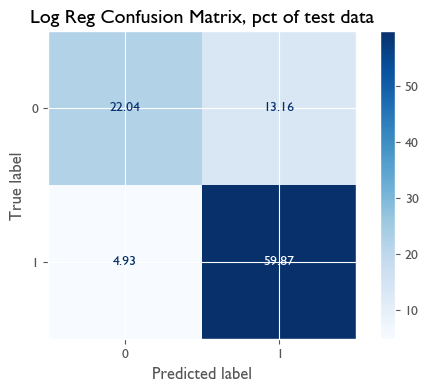

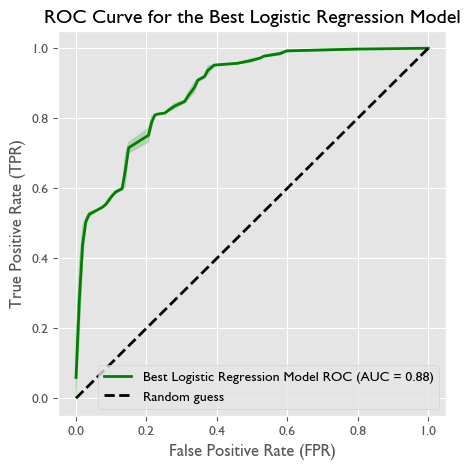

In [51]:
# The best estimator and parameters
best_model_log = grid_search_log.best_estimator_
best_params_log = grid_search_log.best_params_

# Predict the test set and calculate the accuracy
test_predictions_log = best_model_log.predict(X_test)
test_accuracy_log = accuracy_score(y_test, test_predictions_log)

# Print the best hyperparameters and accuracy
print("Best hyperparameters for Logistic Regression:", best_params_log)
print(f"Test Accuracy for Logistic Regression: {test_accuracy_log:.4f}")

# Print classification report and confusion matrix
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, test_predictions_log))
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test, test_predictions_log))

# Display confusion matrix as percentages
cm_log = confusion_matrix(y_test, test_predictions_log) / np.sum(confusion_matrix(y_test, test_predictions_log)) * 100
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp_log.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title("Log Reg Confusion Matrix, pct of test data")
plt.show()

# Predict probabilities and compute ROC curve and AUC for the best model
y_scores_best_log = best_model_log.predict_proba(X_test)[:, 1]
fprs_best_log, tprs_best_log, _ = roc_curve(y_test, y_scores_best_log)
roc_auc_best_log = auc(fprs_best_log, tprs_best_log)

# Plot the ROC curve for the best model
plt.figure(figsize=(5, 5))
sns.lineplot(x=fprs_best_log, y=tprs_best_log, color='green', lw=2, label=f'Best Logistic Regression Model ROC (AUC = {roc_auc_best_log:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')
plt.title('ROC Curve for the Best Logistic Regression Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()


**Model Interpretation:**

* The grid search for optimizing the logistic regression model has yielded promising results. 
* The model demonstrates a test accuracy of approximately 82.9%, which is an improvement over previous iterations. 
* Looking at the classification report, I can see a more balanced performance between the two classes compared to the earlier models.
* The confusion matrix shows that the model correctly predicted 66 instances of the negative class and 186 instances of the positive class. While there's a notable number of false positives (41), the number of false negatives is relatively low (11), suggesting the model's effectiveness in accurately identifying positive intentions.
* Overall, these results are significantly better in terms of accuracy and balance between precision and recall across both classes. 
* I am significantly pelase about recall for minority class improving from 53% to 62%. 
* The model's enhanced ability to distinguish between positive and negative intentions makes it a more reliable tool for this analysis.

Below I am importing the best params into a pipeline for exporting and applying it on the bigger Reddit dataset. 

In [52]:
# Importing the best parameters from the grid search into the pipeline
best_params_log = grid_search_log.best_params_

# Create a new pipeline with the best parameters
best_pipeline_log = Pipeline([
    ('tfidf_log', TfidfVectorizer(
        max_df=best_params_log['tfidf_log__max_df'],
        tokenizer=best_params_log.get('tfidf_log__tokenizer'),  # Using 'get' for optional parameters
        ngram_range=best_params_log['tfidf_log__ngram_range'])),
    ('logr_log', LogisticRegression(
        C=best_params_log['logr_log__C'], 
        solver=best_params_log['logr_log__solver']))
])

# Fit the best pipeline on the full training set
best_pipeline_log.fit(X_train, y_train)

# Best_pipeline_log predictions calculated
test_predictions_log = best_pipeline_log.predict(X_test)

# Predict probabilities for the test set using the best Logistic Regression model
y_scores_best_log = best_pipeline_log.predict_proba(X_test)[:, 1]

# ROC curve and AUC for the best Logistic Regression model
fprs_best_log, tprs_best_log, _ = roc_curve(y_test, y_scores_best_log)
roc_auc_best_log = auc(fprs_best_log, tprs_best_log)

####  Plot showing all logistical model regression ROC curves in one chart

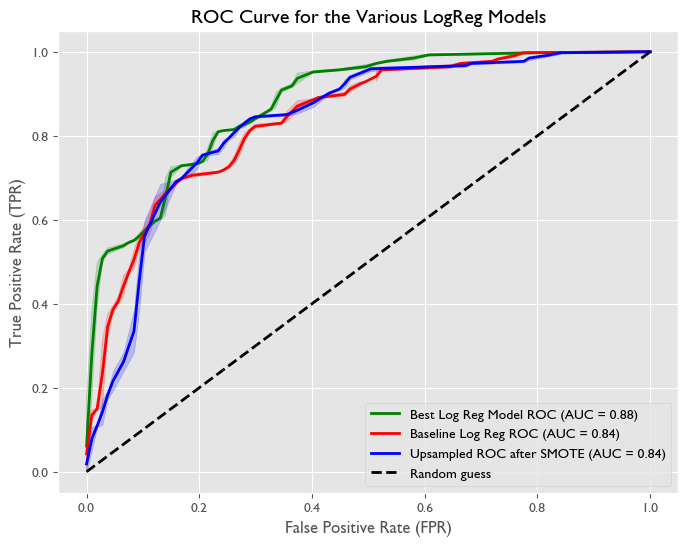

In [53]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fprs_best_log, y=tprs_best_log, color='green', lw=2, label=f'Best Log Reg Model ROC (AUC = {roc_auc_best_log:.2f})') # best model
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'Baseline Log Reg ROC (AUC = {roc_auc:0.2f})') # baseline
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'Upsampled ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')

# Customize the plot
plt.title('ROC Curve for the Various LogReg Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()


The ROC AUC also improved from 83% to 89%, so we can confirm the overall improvement in the log reg model performance after the optimisation above. 

In [54]:
# Retraining my final model on the complete labeled dataset (all data available) before pickling it for future use:
# Fit the best pipeline on the full dataset
best_pipeline_log.fit(X, y)

Pipeline(steps=[('tfidf_log',
                 TfidfVectorizer(max_df=0.6, ngram_range=(1, 2),
                                 tokenizer=<function my_tokenizer at 0x1441485e0>)),
                ('logr_log', LogisticRegression(C=100))])

In [55]:
import joblib

# Specify the file path and name for your pickled object
filename = '../model/03_A_best_pipeline_yes_no.pkl'

# Save your model to a file
joblib.dump(best_pipeline_log, filename)

['../model/03_A_best_pipeline_yes_no.pkl']

## 3.5. Decision Tree Classifier

### 3.5.1. Set up a pipeline

In [57]:
# Create a pipeline with SVD and a decision tree classifier
pipeline_DT = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stop_words)),  # Vectorization
    ('svd', TruncatedSVD()),                          # Dimensionality reduction
    ('clf', DecisionTreeClassifier())                 # Classifier
])

In [58]:
# Define the hyperparameters
param_grid_DT = {
    'vect__max_df': [0.7, 0.8],
    'vect__ngram_range': [(1, 2)],
    'vect__tokenizer': [my_tokenizer],
    'svd__n_components': [100, 200],
    'clf__max_depth': [5],
    'clf__min_samples_split': [5],
    'clf__min_samples_leaf': [3]
}

### 3.5.2. Hyperparameter optimization

 I use GridSearchCV to search over a specified parameter grid. 

In [59]:
# Set up GridSearchCV 
grid_search_DT = GridSearchCV(pipeline_DT, param_grid_DT, cv=5, scoring='f1_weighted', verbose=0, n_jobs=-1, error_score='raise')

In [60]:
# Run the grid search on DT 
grid_search_DT.fit(X_train, y_train)

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('svd', TruncatedSVD()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [5], 'clf__min_samples_leaf': [3],
                         'clf__min_samples_split': [5],
                         'svd__n_components': [100, 200],
                         'vect__max_df': [0.7, 0.8],
                         'vect__ngram_range': [(1, 2)],
                         'vect__tokenizer': [<function my_tokenizer at 0x1441485e0>]},
             scoring='f1_weighted')

In [61]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search_DT.best_params_)

Best hyperparameters: {'clf__max_depth': 5, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'svd__n_components': 200, 'vect__max_df': 0.7, 'vect__ngram_range': (1, 2), 'vect__tokenizer': <function my_tokenizer at 0x1441485e0>}


In [62]:
best_model_DT = grid_search_DT.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds_DT = best_model_DT.predict(X_test)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc_DT = accuracy_score(y_test, test_preds_DT)
print(f"Validation Accuracy with Best Parameters: {val_acc_DT:.4f}")

Validation Accuracy with Best Parameters: 0.7204


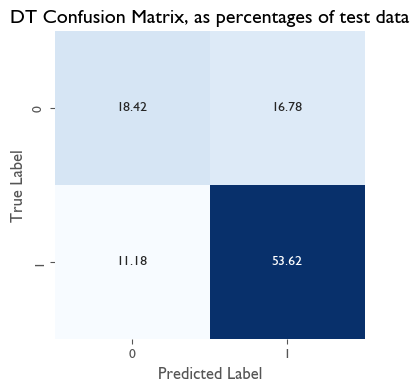

In [63]:
matrix = confusion_matrix(y_test, test_preds_DT)

# Convert confusion matrix to percentages
matrix_percentage = matrix / np.sum(matrix) * 100

plt.figure(figsize=(4, 4))
sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DT Confusion Matrix, as percentages of test data')
plt.show()

In [64]:
# Printing the classification report
report = classification_report(y_test, test_preds_DT)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.52      0.57       107
           1       0.76      0.83      0.79       197

    accuracy                           0.72       304
   macro avg       0.69      0.68      0.68       304
weighted avg       0.71      0.72      0.71       304



**DT model interpretation**

* The Decision Tree classifier's performance, after hyperparameter tuning and grid search, shows a moderate level of accuracy at 73%, which is lower than the previously constructed logistic regression model's accuracy of 83%. 
* The DT model is not able to outperform the baseline accuracy (majority class prediction of 1 with 73% frequency). The model's ability to classify the negative class (n) is limited, with a precision of 62% and a low recall of 59%. This indicates that while the model is somewhat reliable in predicting the majority class (1s), with a high recall of 80%, it frequently misses the minority class (0s), leading to a substantial number of false negatives. 
* The f1-score of 60% for the minority class (0s) is also notably lower than F1 of 79% of the majority class, also shows that the model is conservative in predicting class 0s.

* Comparing the DT classifier to the optimised logreg model built above: 
    *  The Log Reg model has a higher test accuracy (82.89%) compared to the Decision Tree's 73%. This suggests that the Log Reg model is generally more accurate in classifying instances correctly.
    * DT has significantly lower F1 score for the minority class: 0.60 vs 0.72 for logreg.  
    * for the majority class, while both models are effective at identifying positive instances, the Log Reg model is slightly more precise and has a higher recall.
    * Overall, on the macro level, the optimised Log Reg model is more balanced in its performance across both classes
    

* Overall, the DT model is not great at all.  
* The optimized Logistic Regression model outperforms the Decision Tree classifier in terms of overall accuracy, precision, recall, and f1-scores across both classes. 

## 3.6. Support Vector Machine (SVM) Classifier

This section focuses on implementing a Support Vector Machine model for my dataset.  The code snippets below are adapted from Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 300). O'Reilly Media. Kindle Edition. 

In [65]:
X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(1212,)

In [66]:
print(y_test.shape)

(304,)


In [67]:
# Standard Scaling does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [68]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(304, 563)

First, let's try to fit a linear SVM model:

In [69]:
# Use StandardScaler with with_mean=False
svm_clf = make_pipeline(StandardScaler(with_mean=False),                        
                        LinearSVC(C=1, random_state=99, dual=False, max_iter=1000000))

# Fit the model
svm_clf.fit(X_matrix_train_dense, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearsvc',
                 LinearSVC(C=1, dual=False, max_iter=1000000,
                           random_state=99))])

In [70]:
cross_val_score(svm_clf, X_matrix_train, y_train).mean()

0.7442675917423391

Next, I am trying a more complex  polynomial model  to see if this helps to mporve accuracy:

In [71]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

In [72]:
cross_val_score(poly_kernel_svm_clf, X_matrix_train, y_train).mean()

0.7789103152739516

The accuracy score improved a bit, but it is sitll not as high as some other models applied before.  
Let's try to fit a Radial Basis Function kernel: 

In [73]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="rbf", gamma=5, C=0.001))

rbf_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=0.001, gamma=5))])

In [74]:
cross_val_score(rbf_kernel_svm_clf, X_matrix_train, y_train).mean()

0.6485154576063666

The accuracy is not better with the RBF vector.  The polynomial kernel was a better choice.

Next, I will search for the best SVM model by optimising hyperparameters using gridsearch function:

In [75]:
svm_pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, tokenizer=my_tokenizer),
    SVC()
)

In [76]:
# Define the hyperparameters to search, including those for TF-IDF and SVM
param_grid_svm = {
    'tfidfvectorizer__max_df': [0.7, 0.8],
    'tfidfvectorizer__ngram_range': [(1, 2)],
    'svc__kernel': ['poly'], # also tried 'rbf', 'linear'
    'svc__gamma': [0.1, 1, 10],
    'svc__C': [0.01, 0.1, 1],
    'svc__degree': [3, 4, 6],  # Only relevant for 'poly' kernel
    'svc__coef0': [5, 10, 20]   # Only relevant for 'poly' kernel
}

In [77]:
# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='f1_weighted', verbose=0, n_jobs=-1, error_score='raise')

# Run the grid search on the raw text data
grid_search_svm.fit(X_train, y_train)

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_patt

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...],
                                                        tokenizer=<function my_tokenizer at 0x1441485e0>)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.01, 0.1, 1], 'svc__coef0': [5, 10, 20],
                         'svc__degree': [3, 4, 6], 'svc__gamma': [0.1, 1, 10],
                         'svc__kernel': ['poly'],
                         'tfidfvectorizer__max_df': [0.7, 0.8],
                         'tfidfvectorizer__ngram_range': [(1, 2)]},
             scoring='f1_weighted')

In [78]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search_svm.best_params_)

Best hyperparameters: {'svc__C': 0.01, 'svc__coef0': 5, 'svc__degree': 4, 'svc__gamma': 1, 'svc__kernel': 'poly', 'tfidfvectorizer__max_df': 0.7, 'tfidfvectorizer__ngram_range': (1, 2)}


Accuracy: 0.8223684210526315


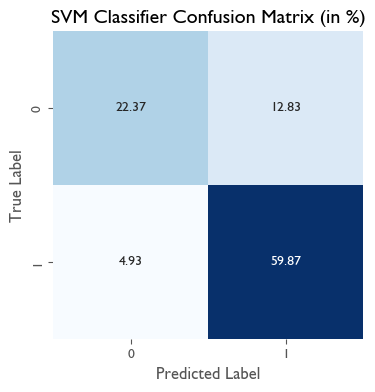

              precision    recall  f1-score   support

           0       0.82      0.64      0.72       107
           1       0.82      0.92      0.87       197

    accuracy                           0.82       304
   macro avg       0.82      0.78      0.79       304
weighted avg       0.82      0.82      0.82       304



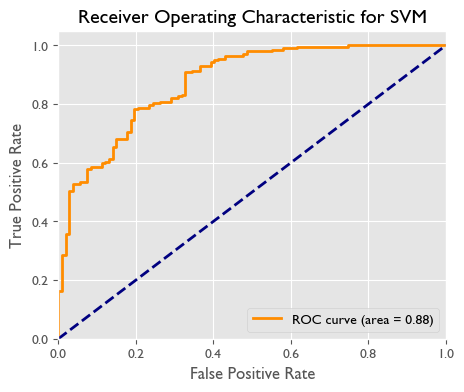

In [79]:
# 1. Build the Best Model
best_hyperparameters = grid_search_svm.best_params_
best_svm_model = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, tokenizer=my_tokenizer, max_df=best_hyperparameters['tfidfvectorizer__max_df'], ngram_range=best_hyperparameters['tfidfvectorizer__ngram_range']),
    SVC(kernel=best_hyperparameters['svc__kernel'], gamma=best_hyperparameters['svc__gamma'], C=best_hyperparameters['svc__C'], degree=best_hyperparameters['svc__degree'], coef0=best_hyperparameters['svc__coef0'], probability=True)
)
best_svm_model.fit(X_train, y_train)

# 2. Calculate Accuracy
test_preds_svm = best_svm_model.predict(X_test)
accuracy = accuracy_score(y_test, test_preds_svm)
print(f'Accuracy: {accuracy}')

# 3. Build Confusion Matrix Plot (percentages)
matrix = confusion_matrix(y_test, test_preds_svm)
matrix_percentage = matrix / np.sum(matrix) * 100
plt.figure(figsize=(4, 4))
sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Classifier Confusion Matrix (in %)')
plt.show()

# 4. Print Classification Report
print(classification_report(y_test, test_preds_svm))

# 5. Build ROC Plot
y_pred_prob = best_svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="lower right")
plt.show()


SVM (Support Vector Machine) model is identical to the one previously discussed for the optimized Logistic Regression (Log Reg) model. Both models show identical classification metrics. 

The Logistic Regression model has a slightly higher ROC AUC (0.89), indicating a marginally better ability to discriminate between the positive and negative classes.

Given that the reported metrics are the same for both models, it suggests that they are equally effective in terms of accuracy, precision, recall, and f1-scores.  These models are nearly identical in performance. 

## 3.7. Random Forest Model

In [80]:
random_forest_model = RandomForestClassifier(n_estimators=500)
random_forest_model.fit(X_matrix_train_dense, y_train)

RandomForestClassifier(n_estimators=500)

In [81]:
# Instantiate lists to save scores in
decision_tree_train_scores = []
decision_tree_test_scores = []
# For each tree, score on train and test
for sub_tree in random_forest_model.estimators_:
    decision_tree_train_scores.append(sub_tree.score(X_matrix_train_dense, y_train))
    decision_tree_test_scores.append(sub_tree.score(X_matrix_test_dense, y_test))

In [82]:
# Predictions on test data
y_pred = random_forest_model.predict(X_matrix_test_dense)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print all metrics
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model.score(X_matrix_train_dense, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model.score(X_matrix_test_dense, y_test)}
Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
F1 Score: {f1}
Confusion Matrix: 
{conf_matrix}
""")


Performance on fitted data:
Average Decision Tree: 0.8862293729372936
Random Forest: 0.9958745874587459
----------------
Performance on test data:
Average Decision Tree: 0.6704605263157893
Random Forest: 0.7828947368421053
Accuracy: 0.7828947368421053
Precision: 0.7799357503144408
Recall: 0.7828947368421053
F1 Score: 0.7808393520389875
Confusion Matrix: 
[[ 70  37]
 [ 29 168]]



In [83]:
# Printing the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       107
           1       0.82      0.85      0.84       197

    accuracy                           0.78       304
   macro avg       0.76      0.75      0.76       304
weighted avg       0.78      0.78      0.78       304



The random forest model performs quite well on the test set, better than the average of its component trees.

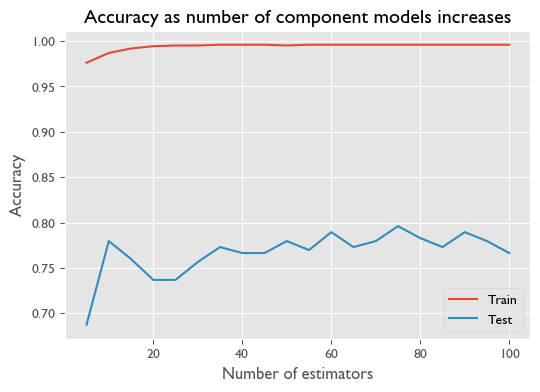

In [84]:
# Observing whether increasing the number of trees in the forest helps to improve accuracy:
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    RF_model = RandomForestClassifier(n_estimators = n)
    RF_model.fit(X_matrix_train_dense, y_train)
    train_scores.append(RF_model.score(X_matrix_train_dense, y_train))
    test_scores.append(RF_model.score(X_matrix_test_dense, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

Train set accuracy is improving until approximately 40 components, and stops improviing after that. Test set accuracy seems to be stable with minor variations past 20 components, but seems to be peaking at n=60.  

I will try to experiment with the depth of each tree in the code below:

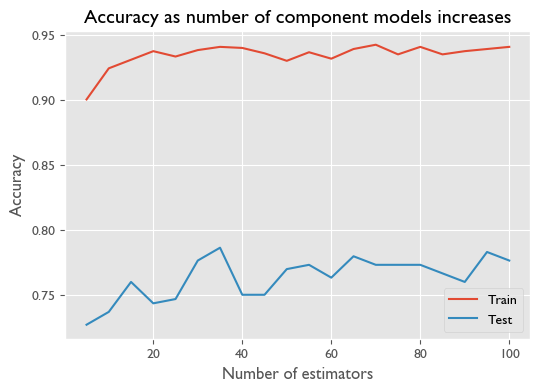

In [85]:
# Observing whether increasing the number of trees in the forest helps to improve accuracy:
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    RF_model = RandomForestClassifier(n_estimators = n,  max_depth =30)
    RF_model.fit(X_matrix_train_dense, y_train)
    train_scores.append(RF_model.score(X_matrix_train_dense, y_train))
    test_scores.append(RF_model.score(X_matrix_test_dense, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

In [86]:
# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=my_tokenizer, token_pattern=None)),  
    ('svd', TruncatedSVD()),
    ('clf', RandomForestClassifier())
])

In [87]:
# Define the parameter grid
param_grid = {
    'tfidf__tokenizer': [my_tokenizer],
    'svd__n_components': [200,300], 
    'clf__n_estimators': [60, 80, 83, 100],
    'clf__max_depth': [30],
    'clf__max_features': [20, 30, 40]
}

In [88]:
# Create a grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=0, n_jobs=-1, error_score='raise')

In [89]:
# Run the grid search on Random Forest 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(token_pattern=None,
                                                        tokenizer=<function my_tokenizer at 0x1441485e0>)),
                                       ('svd', TruncatedSVD()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [30],
                         'clf__max_features': [20, 30, 40],
                         'clf__n_estimators': [60, 80, 83, 100],
                         'svd__n_components': [200, 300],
                         'tfidf__tokenizer': [<function my_tokenizer at 0x1441485e0>]},
             scoring='f1_weighted')

Best hyperparameters for Random Forest: {'clf__max_depth': 30, 'clf__max_features': 30, 'clf__n_estimators': 100, 'svd__n_components': 200, 'tfidf__tokenizer': <function my_tokenizer at 0x1441485e0>}
Accuracy: 0.7927631578947368


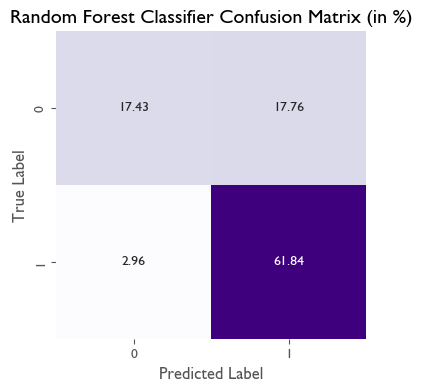

              precision    recall  f1-score   support

           0       0.85      0.50      0.63       107
           1       0.78      0.95      0.86       197

    accuracy                           0.79       304
   macro avg       0.82      0.72      0.74       304
weighted avg       0.80      0.79      0.78       304



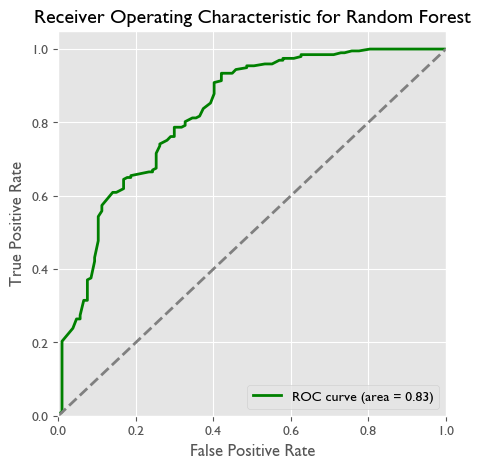

In [90]:
# 1. Get the best estimator and parameters
best_hyperparameters_rf = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
print("Best hyperparameters for Random Forest:", best_hyperparameters_rf)

# 2. Calculate Accuracy
test_preds = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, test_preds)
print(f'Accuracy: {accuracy}')

# 3. Build Confusion Matrix Plot (percentages)
matrix = confusion_matrix(y_test, test_preds)
matrix_percentage = matrix / np.sum(matrix) * 100
plt.figure(figsize=(4, 4))
sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap="Purples", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Classifier Confusion Matrix (in %)')
plt.show()

# 4. Print Classification Report
print(classification_report(y_test, test_preds))

# 5. Build ROC Plot (using a different color)
if hasattr(best_rf_model, "predict_proba"):
    y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Changed color to green
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Random Forest')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Random Forest model does not support probability predictions.")


Comparing the performance of the Random Forest and Logistic Regression models based on the provided metrics gives me the following insights:

* Logistic Regression shows higher overall accuracy (better by 7%).
* Random Forest: Precision = 77%, Recall = 47%. This is quite a bit lower than for the log reg (precision = 86%, recall = 62%)
* Logistic Regression has higher precision and recall for both classes (), indicating a better balance between correctly identifying each class.
* Logistic Regression has higher F1-scores for both classes (by 5-14%), suggesting better overall performance in balancing precision and recall.
* The area under the ROC curve is higher for Logistic Regression by 5%, indicating a better ability to discriminate between the positive and negative classes.
* Log Reg shows higher macro and weighted average scores, reflecting its superior performance across both classes.

Overall, on all counts the Logreg is a better model than Random forest. 

## 3.8. Conclusion on the Yes/No encoding strategy

In [91]:
# All the models listed
models = {
    "Logistic Regression": (y_test, test_predictions_log),
    "Decision Tree": (y_test, test_preds_DT),
    "Support Vector Machine": (y_test, test_preds_svm),
    "Random Forest": (y_test, test_preds), 
}

# List to store model names 
model_metrics = []

# Iterating through the models and calculate metrics
for model_name, (true_labels, predicted_labels) in models.items():
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision_scores = precision_score(true_labels, predicted_labels, average=None)
    recall_scores = recall_score(true_labels, predicted_labels, average=None)
    f1_scores = f1_score(true_labels, predicted_labels, average=None)
    macro_precision = np.mean(precision_scores)
    macro_recall = np.mean(recall_scores)
    macro_f1 = np.mean(f1_scores)

    # Calculate confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Generate classification report
    report = classification_report(true_labels, predicted_labels)

    model_metric = {
        "Model": model_name,
        "Accuracy": accuracy,
        "Class 1 Precision": precision_scores[1],
        "Class 1 Recall": recall_scores[1],
        "Class 0 Precision": precision_scores[0],
        "Class 0 Recall": recall_scores[0],
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1 Score": macro_f1,
        "Confusion Matrix": confusion,
    }

    model_metrics.append(model_metric)

# Create a summary DataFrame
summary_df = pd.DataFrame(model_metrics)

# Display the summary DataFrame
summary_df

,Model,Accuracy,Class 1 Precision,Class 1 Recall,Class 0 Precision,Class 0 Recall,Macro Precision,Macro Recall,Macro F1 Score,Confusion Matrix
0,Logistic Regression,0.82,0.82,0.92,0.82,0.63,0.82,0.78,0.79,"[[67, 40], [15, 182]]"
1,Decision Tree,0.72,0.76,0.83,0.62,0.52,0.69,0.68,0.68,"[[56, 51], [34, 163]]"
2,Support Vector Machine,0.82,0.82,0.92,0.82,0.64,0.82,0.78,0.79,"[[68, 39], [15, 182]]"
3,Random Forest,0.79,0.78,0.95,0.85,0.50,0.82,0.72,0.74,"[[53, 54], [9, 188]]"


The two best models are SVM and the optimised Logreg. they are nerly identical in their performance.  They both have the highest macro F1 score of 0.79.

Below I plot their ROC curves, they are nearly the same (they differ by only one row in their classifications):

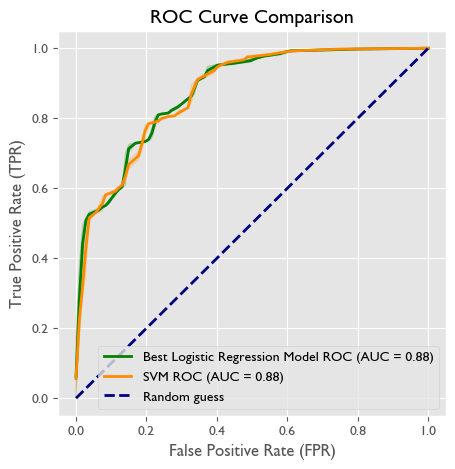

In [94]:
# Calculating for the best Logistic Regression model
fprs_best_log, tprs_best_log, _ = roc_curve(y_test, y_scores_best_log)
roc_auc_best_log = auc(fprs_best_log, tprs_best_log)

# For the SVM model
y_pred_prob_svm = best_svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plotting both ROC curves
plt.figure(figsize=(5, 5))
sns.lineplot(x=fprs_best_log, y=tprs_best_log, color='green', lw=2, label=f'Best Logistic Regression Model ROC (AUC = {roc_auc_best_log:.2f})')
sns.lineplot(x=fpr_svm, y=tpr_svm, color='darkorange', lw=2, label=f'SVM ROC (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()


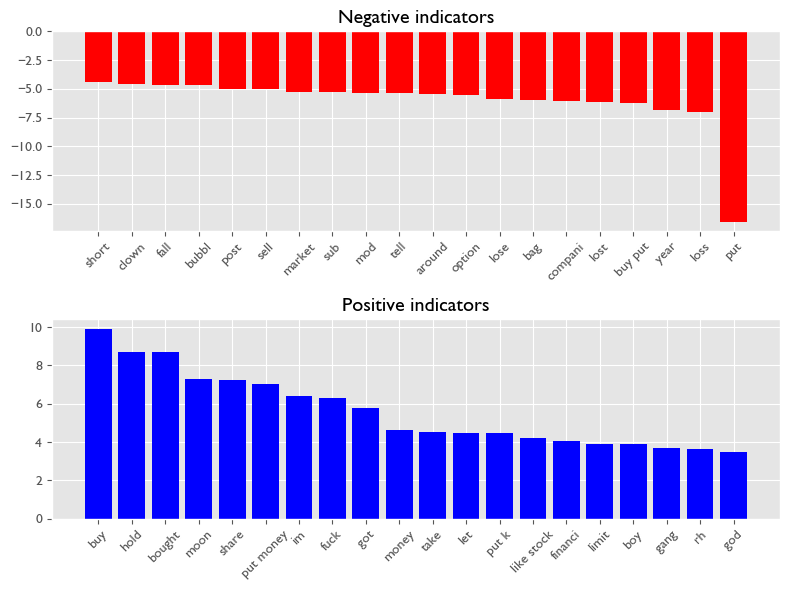

In [95]:
# Plotting the best log reg coefficients 

def plot_coefs(pipeline):
    # Extract the Logistic Regression model and TfidfVectorizer from the pipeline
    vectorizer = pipeline.named_steps['tfidf_log']
    model = pipeline.named_steps['logr_log']
    
    # Create a dataframe to store the coefficients 
    coef_df = pd.DataFrame({
        "coefficient": model.coef_[0], 
        "token": vectorizer.get_feature_names_out()
    })

    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Plot tokens with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

# Plotting coefficients for the best_pipeline_log model
plot_coefs(best_pipeline_log)


Plotting the coefficients for the optimised logreg model above I can see that the weights of different coefficients significantly changed, compared to the baseline logreg model I plotted earlier.  

* On the positive side, words like "buy", "bought", "put money", "got", "share" has gained in significance, and in the second dozen some new words got completely replaced.  
* On the negative side, the word "put" gained in significance, and is now THE most significant word in the collection, more than double the weight of the second most significant word. 
* New negative words appeared: the word "year" came out of nowhere into the third position. The bigram "buy put" is now one of the top coefficients, which is logfically correct.  
* There are still many common words on the negative list, and they can be used in many other messages, such as "china", "option", "around', indicating the small size of the dataset is still an issue and needs to be addressed.


**As a result of all the steps above, I decided to use will use the LogReg model for pickling and applying on the larger Reddit dataset, as it is easier to interpret**.

